In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from numpy import unique, where
from collections import Counter
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import torch

import sys
sys.path.append("..")
from util.vis import t_sne, pca
from util.style_model import StyleModel
from util.clustering_eval import clustering_summary, print_clustering_classes, clustering_spacy_evaluation

In [2]:
test_data = pd.read_pickle('../data/04-0c_Test_Set.pkl')

# Style Embeddings from Style Model

In [3]:
model = StyleModel()
model.load_state_dict(torch.load('../model/StyleModel.pt'))

<All keys matched successfully>

In [4]:
messages = test_data["message"].tolist()

vectors = []

for message in tqdm(messages):
    vectors.append(model(message).squeeze().detach().numpy())

vectors = np.array(vectors)

100%|██████████| 14235/14235 [05:26<00:00, 43.66it/s]


## Centroids

In [5]:
authors_centroids = {}

for group in test_data.groupby('author_email'):
    author_embeddings = np.array(vectors[group[1].index])
    authors_centroids[group[0]] = np.mean(author_embeddings, axis = 0)

In [6]:
centroids_array = [value for value in authors_centroids.values()]

distances = pd.DataFrame(euclidean_distances(centroids_array, centroids_array))

for i in range(len(distances)):
    for j in range(i + 1):
        distances[j][i] = 0

distances.index = ['Author 1', 'Author 2', 'Author 3', 'Author 4', 'Author 5', 'Author 6', 'Author 7']
distances.columns = ['Author 1', 'Author 2', 'Author 3', 'Author 4', 'Author 5', 'Author 6', 'Author 7']

distances.style.background_gradient(cmap='coolwarm').set_precision(3)

,Author 1,Author 2,Author 3,Author 4,Author 5,Author 6,Author 7
Author 1,0.000,0.537,0.309,0.260,0.270,0.937,0.310
Author 2,0.000,0.000,0.409,0.487,0.426,0.991,0.569
Author 3,0.000,0.000,0.000,0.327,0.214,0.983,0.311
Author 4,0.000,0.000,0.000,0.000,0.292,0.840,0.391
Author 5,0.000,0.000,0.000,0.000,0.000,0.942,0.370
Author 6,0.000,0.000,0.000,0.000,0.000,0.000,0.991
Author 7,0.000,0.000,0.000,0.000,0.000,0.000,0.000


## PCA & t-SNE Visualizations

First, the generated vectors are reduced to two and three dimensions with PCA and t-SNE and visualized. Each of the seven authors gets a different color.

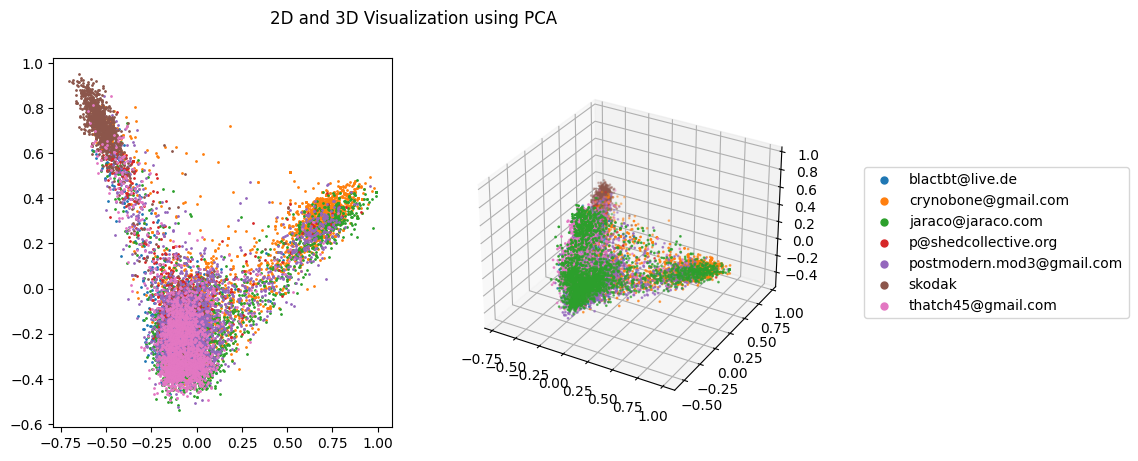

In [7]:
pca_2_prediction, pca_3_prediction = pca(vectors, test_data)

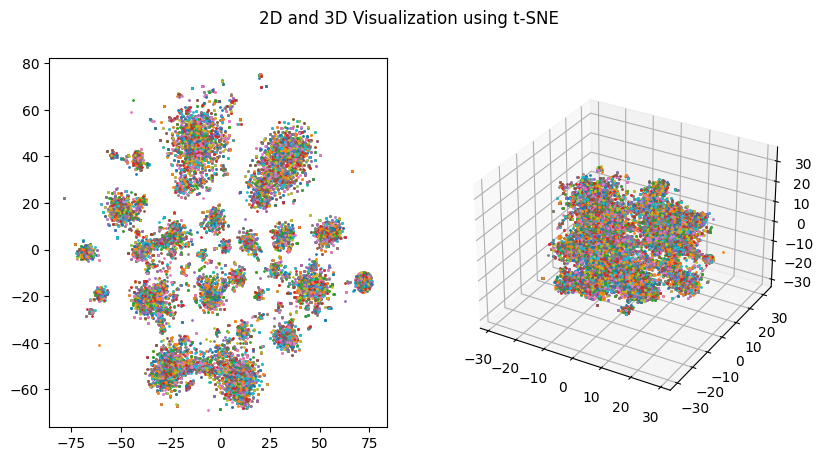

In [8]:
t_sne_2_prediction, t_sne_3_prediction = t_sne(vectors, test_data, legend=False)

## DBSCAN

DBSCAN: Density-based, no number of clusters needed, ability to provide min_samples to make one cluster

Number of Clusters: 6
10 Most common:
[(0, 12128), (-1, 2050), (3, 24), (1, 13), (2, 10), (4, 10)]


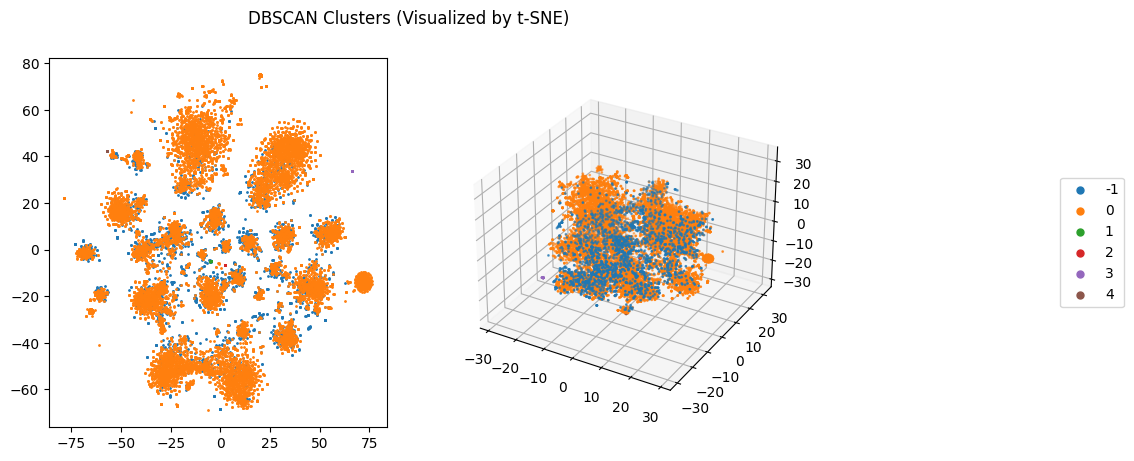

In [9]:
dbscan_model = DBSCAN(eps=0.7, min_samples=10)
dbscan_prediction = dbscan_model.fit_predict(vectors)

dbscan_clusters = unique(dbscan_prediction)

print(f"Number of Clusters: {len(dbscan_clusters)}")
print("10 Most common:")
print(Counter(dbscan_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for dbscan_cluster in dbscan_clusters:
    index = where(dbscan_prediction == dbscan_cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=dbscan_cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=dbscan_cluster)

fig.suptitle("DBSCAN Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [10]:
dbscan_summary = clustering_summary(dbscan_prediction, test_data)
dbscan_summary

There are 7 different authors.
There are 214 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,2050.0,7.0,317.0,"('postmodern.mod3@gmail.com', 442)",148.0,3.0,"('meew0_discordrb', 310)"
1,12128.0,7.0,1697.0,"('crynobone@gmail.com', 2668)",209.0,10.0,"('saltstack_salt', 1697)"
2,13.0,6.0,2.0,"('jaraco@jaraco.com', 4)",10.0,1.0,"('meew0_discordrb', 3)"
3,10.0,1.0,10.0,"('crynobone@gmail.com', 10)",1.0,10.0,"('orchestral_testbench-core', 10)"
4,24.0,1.0,24.0,"('jaraco@jaraco.com', 24)",16.0,1.0,"('jazzband_inflect', 6)"
5,10.0,1.0,10.0,"('p@shedcollective.org', 10)",9.0,1.0,"('nails_module-cron', 2)"


In [11]:
dbscan_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,6.000000,6.000000,6.000000,6.000000,6.000000
mean,2372.500000,3.833333,343.333333,65.500000,4.333333
std,4848.077794,3.125167,674.360635,89.756894,4.457204
min,10.000000,1.000000,2.000000,1.000000,1.000000
25%,10.750000,1.000000,10.000000,9.250000,1.000000
50%,18.500000,3.500000,17.000000,13.000000,2.000000
75%,1543.500000,6.750000,243.750000,115.000000,8.250000
max,12128.000000,7.000000,1697.000000,209.000000,10.000000


In [12]:
clustering_spacy_evaluation(dbscan_prediction, test_data)

,0,1,2,3,4,5
length_mean,59.006341,52.732108,65.384615,96.200000,28.000000,47.200000
length_std,37.334290,34.652031,32.457163,3.544009,0.000000,3.867816
n_uppercase_mean,2.632195,2.971059,2.692308,10.800000,1.000000,18.100000
n_uppercase_std,2.794828,4.073824,3.290654,1.536229,0.000000,4.392038
polarity_mean,0.029084,0.011596,0.027473,0.000000,0.000000,0.000000
polarity_std,0.172524,0.157789,0.137448,0.000000,0.000000,0.000000
subjectivity_mean,0.168102,0.146877,0.167445,0.000000,0.000000,0.133333
subjectivity_std,0.275321,0.261551,0.224369,0.000000,0.000000,0.163299


In [13]:
print_clustering_classes(dbscan_prediction, test_data)


________________ Class 0 ________________

___
1) 
Copy over WSCS' open? method

This should be everything - the websocket backend behind the gateway should be fully functioning.
___
2) 
Add an initializer to ReactionEvent
___
3) 
Implement Discord rate limiting in a blocking way
___
4) 
Track role mentions in messages along with user mentions
___
5) 
Fix guild vs. server in the send_voice_state_update doc comment
___
6) 
Add methods to check whether channels are text or voice ones
___
7) 
Rename the Bot#stop method to #kill to more accurately reflect its purpose
___
8) 
Wait one packet after stopping playback to ensure it has stopped
___
9) 
Make should_connect_to_voice a hash too
___
10) 
Use resolve_id for banning, unbanning and kicking (allows banning of non-members)
_________________

Number of messages in this class: 2050
Most common author:
('postmodern.mod3@gmail.com', 442)
Most common project:
('meew0_discordrb', 310)



________________ Class 1 ________________

___
1) 
Add 

## K-Means

Centroid-Based, fixed number of Clusters

Goal: Find seven clusters for seven authors

In [14]:
silhouette_scores = []
k_range = range(3, 15, 1)

for k in k_range:
    kmeans = KMeans(k)
    kmeans_prediction = kmeans.fit_predict(vectors)
    silhouette_scores.append(silhouette_score(vectors, kmeans_prediction))

k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"Number of clusters with max silhouette score: {k}")

Number of clusters with max silhouette score: 14


Number of Clusters: 14
10 Most common:
[(0, 2212), (1, 2039), (3, 1734), (2, 1449), (4, 1108), (6, 1097), (8, 922), (13, 707), (5, 645), (11, 587)]


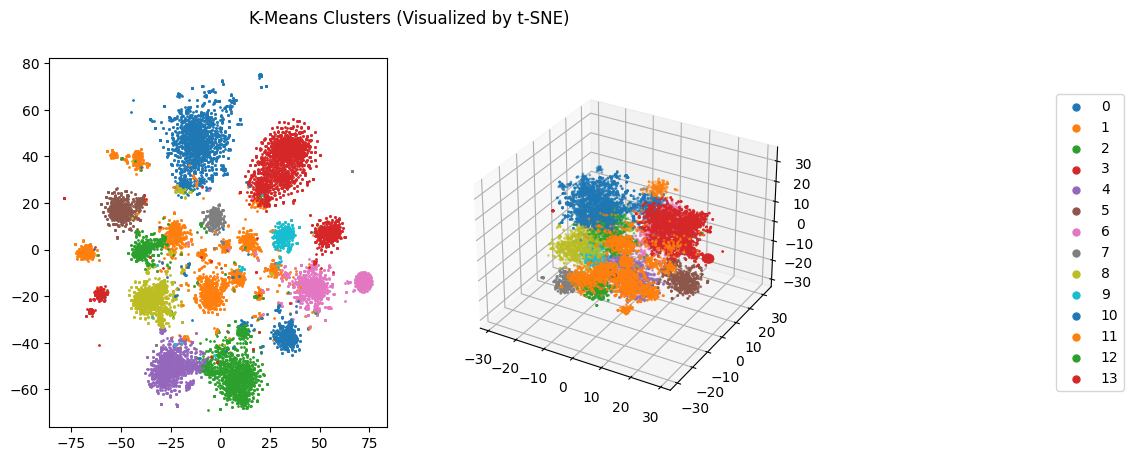

In [15]:
kmeans = KMeans(k)
kmeans_prediction = kmeans.fit_predict(vectors)

kmeans_clusters = unique(kmeans_prediction)

print(f"Number of Clusters: {len(kmeans_clusters)}")
print("10 Most common:")
print(Counter(kmeans_prediction).most_common(10))

fig = plt.figure(figsize=plt.figaspect(0.5))
ax2 = fig.add_subplot(1, 2, 1)
ax3 = fig.add_subplot(1, 2, 2, projection='3d')

for cluster in kmeans_clusters:
    index = where(kmeans_prediction == cluster)[0]
    ax2.scatter(t_sne_2_prediction[index, 0], t_sne_2_prediction[index, 1], s=1, label=cluster)
    ax3.scatter(t_sne_3_prediction[index, 0], t_sne_3_prediction[index, 1], t_sne_3_prediction[index, 2], s=1, label=cluster)

fig.suptitle("K-Means Clusters (Visualized by t-SNE)")
plt.legend(loc=5, bbox_to_anchor=(2, 0.5), markerscale = 5)
plt.show()

In [16]:
kmeans_summary = clustering_summary(kmeans_prediction, test_data)
kmeans_summary

There are 7 different authors.
There are 214 different projects.


,Number of Messages,Number of different Authors,Median number of commits per different Author,Most common Author,Number of different Projects,Median number of commits per different Project,Most common project
0,2212.0,7.0,35.0,"('crynobone@gmail.com', 1458)",144.0,5.0,"('orchestral_foundation', 239)"
1,2039.0,7.0,303.0,"('p@shedcollective.org', 534)",140.0,4.0,"('meew0_discordrb', 312)"
2,1449.0,7.0,228.0,"('thatch45@gmail.com', 421)",130.0,3.0,"('saltstack_salt', 421)"
3,1734.0,7.0,137.0,"('skodak', 1067)",92.0,2.0,"('moodle_moodle', 1067)"
4,1108.0,7.0,71.0,"('thatch45@gmail.com', 576)",90.0,2.0,"('saltstack_salt', 576)"
5,645.0,7.0,51.0,"('postmodern.mod3@gmail.com', 312)",101.0,2.0,"('ronin-ruby_ronin', 141)"
6,1097.0,7.0,59.0,"('jaraco@jaraco.com', 586)",105.0,2.0,"('pypa_setuptools', 259)"
7,355.0,6.0,48.5,"('blactbt@live.de', 120)",69.0,2.0,"('meew0_discordrb', 117)"
8,922.0,7.0,78.0,"('postmodern.mod3@gmail.com', 348)",116.0,2.5,"('ronin-ruby_ronin', 175)"
9,423.0,6.0,61.5,"('blactbt@live.de', 160)",56.0,2.0,"('meew0_discordrb', 159)"


In [17]:
kmeans_summary.describe()

,Number of Messages,Number of different Authors,Median number of commits per different Author,Number of different Projects,Median number of commits per different Project
count,14.000000,14.000000,14.000000,14.000000,14.000000
mean,1016.785714,6.785714,94.464286,99.071429,2.428571
std,619.431523,0.425815,77.862172,26.289700,0.957905
min,355.000000,6.000000,35.000000,56.000000,1.500000
25%,519.500000,7.000000,52.000000,86.750000,2.000000
50%,814.500000,7.000000,66.250000,95.500000,2.000000
75%,1363.750000,7.000000,78.750000,113.250000,2.375000
max,2212.000000,7.000000,303.000000,144.000000,5.000000


In [18]:
spacy_summary = clustering_spacy_evaluation(kmeans_prediction, test_data)
spacy_summary

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
length_mean,36.922242,63.214811,50.147688,64.585928,65.514440,44.609302,59.344576,54.200000,54.232104,55.364066,55.637827,57.071550,48.189130,36.471004
length_std,31.805798,38.936827,32.440468,32.927314,43.953996,23.905419,31.958807,38.849685,29.950363,32.504734,28.992152,33.599023,24.672575,26.536254
n_uppercase_mean,1.829114,3.049044,1.776398,7.731257,2.101986,2.336434,2.670921,1.985915,2.232104,1.921986,3.126761,2.337308,2.097826,1.840170
n_uppercase_std,1.811332,3.664919,2.035495,7.272056,2.563186,2.091694,2.643891,1.924585,2.232750,2.665969,2.722961,2.181388,2.254752,2.594450
polarity_mean,-0.004498,0.014599,0.008967,0.022941,0.020600,0.023979,0.025286,0.009162,0.019325,0.020612,0.024636,0.014645,0.019109,0.003639
polarity_std,0.140469,0.167484,0.174611,0.169598,0.166711,0.123582,0.149991,0.168544,0.150568,0.206468,0.158354,0.172903,0.161644,0.125362
subjectivity_mean,0.102802,0.175230,0.154920,0.190851,0.171361,0.108250,0.121537,0.148949,0.161764,0.221721,0.133044,0.170806,0.131386,0.104221
subjectivity_std,0.236190,0.284935,0.281512,0.248774,0.277056,0.224640,0.237960,0.268876,0.283800,0.323681,0.242604,0.286446,0.238679,0.215588


In [19]:
print_clustering_classes(kmeans_prediction, test_data)


________________ Class 0 ________________

___
1) 
Fix a missing route-based key
___
2) 
Rename find to find_channel and add a (deprecated) alias
___
3) 
Order the Gateway#handle_xyz methods by opcode

What a useless change.
___
4) 
Add a utility method to check whether users are webhook users
___
5) 
Add a utility method to check whether a message was sent by a webhook
___
6) 
Add a basic test for #fixture
___
7) 
Make a constant for the log timestamp format so we don't keep allocating it
___
8) 
Style fix with should_delete
___
9) 
If we're saying we're measuring the encoding, we should probably not be measuring the networking instead...
___
10) 
Cast parsed IDs to integers in role mention parsing

Apparently role mention parsing never worked at all and nobody noticed...
_________________

Number of messages in this class: 2212
Most common author:
('crynobone@gmail.com', 1458)
Most common project:
('orchestral_foundation', 239)



________________ Class 1 ________________

___
1) 
: